In [1]:

from roboflow import Roboflow
rf = Roboflow(api_key="htpcxp3XQh7SsgMfjJns")
project = rf.workspace("ownprojects").project("basketball-w2xcw")
dataset = project.version(2).download("yolov8")


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.178, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to Basketball-2 in yolov8:: 100%|██████████| 19490/19490 [01:11<00:00, 274.44it/s]


In [1]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

ModuleNotFoundError: No module named 'torch'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
import os
from pathlib import Path

# the path to BasketBall-2 dataset is object_detection_roboflow\validation_notebooks\Basketball-2
#what path does Path() return?
# Path() returns the current working directory
# Path.cwd() returns the current working directory
# Path.home() returns the home directory

print(Path.cwd())
print(Path.home())
print(Path('Basketball-2'))

image_path = Path('Basketball-2')


def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


walk_through_dir(image_path)

c:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\DL\git\Deep_learning\object_detection_roboflow\validation_notebooks
C:\Users\ghadf
Basketball-2
There are 3 directories and 3 images in 'Basketball-2'.
There are 2 directories and 0 images in 'Basketball-2\test'.
There are 0 directories and 406 images in 'Basketball-2\test\images'.
There are 0 directories and 406 images in 'Basketball-2\test\labels'.
There are 2 directories and 0 images in 'Basketball-2\train'.
There are 0 directories and 8521 images in 'Basketball-2\train\images'.
There are 0 directories and 8521 images in 'Basketball-2\train\labels'.
There are 2 directories and 0 images in 'Basketball-2\valid'.
There are 0 directories and 812 images in 'Basketball-2\valid\images'.
There are 0 directories and 812 images in 'Basketball-2\valid\labels'.


Random image path: Basketball-2\train\images\133_jpg.rf.220b22545bb526689181d35bf17afd5b.jpg
Image class: images
Image height: 416
Image width: 416


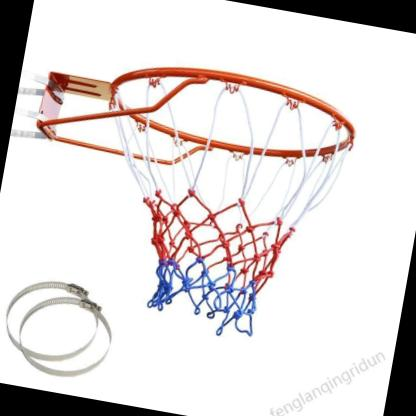

In [4]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

add in a bounding box checker for before and after transformations

In [5]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image


# Define a consistent transform for images
def get_transform(train):
    transforms_list = [transforms.ToTensor()]
    if train:
        transforms_list.extend([
            transforms.Resize((224, 224), antialias=True),
            transforms.RandomHorizontalFlip(0.5)
        ])
    else:
        transforms_list.append(transforms.Resize((224, 224), antialias=True))
    return transforms.Compose(transforms_list)


In [6]:
def verify_and_correct_boxes(boxes, image_width, image_height):
    corrected_boxes = []
    for box in boxes:
        # Extract coordinates
        x_center, y_center, box_width, box_height = box

        # Convert centers to top-left coordinates
        x_min = (x_center - box_width / 2) * image_width
        y_min = (y_center - box_height / 2) * image_height

        # Ensure width and height are positive
        box_width = abs(box_width * image_width)
        box_height = abs(box_height * image_height)

        # Convert to bottom-right coordinates
        x_max = x_min + box_width
        y_max = y_min + box_height

        # Clip boxes that are out of image bounds
        x_min = max(0, min(x_min, image_width - 1))
        y_min = max(0, min(y_min, image_height - 1))
        x_max = max(x_min + 1, min(x_max, image_width))
        y_max = max(y_min + 1, min(y_max, image_height))

        corrected_boxes.append((x_min, y_min, x_max, y_max))

    return torch.tensor(corrected_boxes, dtype=torch.float32)


In [7]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.img_names = [img_name for img_name in os.listdir(img_dir) if img_name.endswith('.jpg')]

    def load_labels(self, label_path):
        with open(label_path, 'r') as file:
            labels = file.read().splitlines()

        annotations = []
        for label in labels:
            elements = label.split()
            # Only process labels with exactly 5 elements
            if len(elements) == 5:
                class_label, x_center, y_center, width, height = map(float, elements)
                annotations.append((class_label, x_center, y_center, width, height))
            else:
                print(f"Skipping invalid label in {label_path}: {label}")
        return annotations

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        label_path = os.path.join(self.label_dir, self.img_names[idx].replace('.jpg', '.txt'))
        image = Image.open(img_path).convert('RGB')

        # Store original image size before transformation
        orig_width, orig_height = image.size

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # If your transforms include resizing, then you should get the new size from the transformed image
        if isinstance(image, torch.Tensor):
            # For tensors, the size is in the shape attribute
            img_height, img_width = image.shape[-2:]
        else:
            # If the image is not a tensor, it's still a PIL image, and we can use the size method
            img_width, img_height = image.size

        annotations = self.load_labels(label_path)
        boxes = [ann[1:] for ann in annotations]  # Extract only the bounding box coordinates
        corrected_boxes = verify_and_correct_boxes(boxes, orig_width, orig_height)  # Use the original size here for correction

        labels = [ann[0] for ann in annotations]  # Extract only the labels
        labels = torch.tensor(labels, dtype=torch.int64)  # Convert labels to tensor

        image_id = torch.tensor([idx])
        area = (corrected_boxes[:, 3] - corrected_boxes[:, 1]) * (corrected_boxes[:, 2] - corrected_boxes[:, 0])
        iscrowd = torch.zeros((len(annotations),), dtype=torch.int64)

        target = {
            "boxes": corrected_boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd
        }

        return image, target


In [8]:
# Set up the dataset and dataloader
train_data = CustomDataset(
    img_dir='Basketball-2/train/images',
    label_dir='Basketball-2/train/labels',
    transform=get_transform(train=True)
)

test_data = CustomDataset(
    img_dir='Basketball-2/test/images',
    label_dir='Basketball-2/test/labels',
    transform=get_transform(train=False)
)

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = DataLoader(
    train_data, batch_size=2, shuffle=True, collate_fn=collate_fn, num_workers=2
)
test_dataloader = DataLoader(
    test_data, batch_size=2, shuffle=False, collate_fn=collate_fn, num_workers=2
)

In [10]:
# Model setup
num_classes = 6  # 5 classes + background

model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [11]:
from torchvision.ops import box_iou

 #New IoU based metrics calculation function
def calculate_iou_metrics(pred_boxes, true_boxes, iou_threshold=0.5):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for pred, true in zip(pred_boxes, true_boxes):
        # Check if either predicted or true boxes are empty
        if pred['boxes'].nelement() == 0 or true['boxes'].nelement() == 0:
            if pred['boxes'].nelement() == 0 and true['boxes'].nelement() != 0:
                false_negatives += len(true['boxes'])
            continue

        iou = box_iou(pred['boxes'], true['boxes'])

        for i in range(len(pred['boxes'])):
            if iou[i].max() > iou_threshold:
                true_positives += 1
            else:
                false_positives += 1

        false_negatives += len(true['boxes']) - iou.max(dim=0)[0].sum().item()

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0
    return precision, recall


In [12]:
def calculate_accuracy(pred_boxes, true_boxes, iou_threshold=0.5):
    accuracy = 0.0
    for pred, true in zip(pred_boxes, true_boxes):
        iou = box_iou(pred['boxes'], true['boxes'])
        correct_predictions = iou > iou_threshold

        # Check for division by zero
        if correct_predictions.numel() == 0:
            continue

        accuracy += correct_predictions.sum().item() / correct_predictions.numel()
    return accuracy / len(pred_boxes) if len(pred_boxes) > 0 else 0.0

In [ ]:
# Training function remains the same
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    for batch, (images, targets) in enumerate(data_loader):
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        if not torch.isfinite(losses):
            print("Loss is not finite, stopping training.")
            return None

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_loss += losses.item()
        train_accuracy += calculate_accuracy(targets, targets)

    train_loss /= len(data_loader)
    train_accuracy /= len(data_loader)

    print(f"train_loss: {train_loss}, train_accuracy: {train_accuracy}")
    return train_loss, train_accuracy



In [ ]:
# Modified evaluate function
def evaluate(model, data_loader, device):
    model.eval()
    test_precision = 0.0
    test_recall = 0.0
    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            preds = model(images)

            precision, recall = calculate_iou_metrics(preds, targets)
            test_precision += precision
            test_recall += recall

    test_precision /= len(data_loader)
    test_recall /= len(data_loader)

    print(f"test_precision: {test_precision}, test_recall: {test_recall}")
    return test_precision, test_recall


In [ ]:
# Adjusted train and evaluate loop
def train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, lr_scheduler, device, num_epochs):
    train_losses = []
    test_iou_scores = []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train_one_epoch(model, optimizer, train_dataloader, device, epoch)
        if train_loss is None:
            print("Training stopped due to an error.")
            break

        test_precision, test_recall = evaluate(model, test_dataloader, device)
        if test_precision is None or test_recall is None:
            print("Evaluation stopped due to an error.")
            break

        lr_scheduler.step()

        train_losses.append(train_loss)
        test_iou_scores.append((test_precision, test_recall))

        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Train accuracy: {train_accuracy}, Test precision: {test_precision}, Test recall: {test_recall}")

    return train_losses, test_iou_scores



In [ ]:
# Simplified training loop setup
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 10

# Train the model and get metrics
train_losses, test_iou_scores = train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, lr_scheduler, device, num_epochs)


# Call the train_and_evaluate function
#train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, lr_scheduler, device, num_epochs)

Looking at training and test loss curves is a great way to see if your model is overfitting.

An overfitting model is one that performs better (often by a considerable margin) on the training set than the validation/test set.

If your training loss is far lower than your test loss, your model is overfitting.

As in, it's learning the patterns in the training too well and those patterns aren't generalizing to the test data.

The other side is when your training and test loss are not as low as you'd like, this is considered underfitting.

The ideal position for a training and test loss curve is for them to line up closely with each other

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training loss
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the testing IoU
plt.figure(figsize=(12, 6))
plt.plot(test_iou_scores, label='Testing IoU Score', color='orange')
plt.title('Testing IoU Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU Score')
plt.legend()
plt.show()
